In [1]:
library(tidyverse)
library(repr)
library(tidymodels) 
install.packages("kknn")
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Read and assign our csv weather dataset into `weather`

In [2]:
weather <- read_csv("weather_data.csv")
head(weather) 

Rows: 8784 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Date/Time, Weather
dbl (6): Temp_C, Dew Point Temp_C, Rel Hum_%, Wind Speed_km/h, Visibility_km...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date/Time     Temp_C Dew Point Temp_C Rel Hum_% Wind Speed_km/h Visibility_km
1 1/1/2012 0:00 -1.8   -3.9             86        4               8.0          
2 1/1/2012 1:00 -1.8   -3.7             87        4               8.0          
3 1/1/2012 2:00 -1.8   -3.4             89        7               4.0          
4 1/1/2012 3:00 -1.5   -3.2             88        6               4.0          
5 1/1/2012 4:00 -1.5   -3.3             88        7               4.8          
6 1/1/2012 5:00 -1.4   -3.3             87        9               6.4          
  Press_kPa Weather             
1 101.24    Fog                 
2 101.24    Fog                 
3 101.26    Freezing Drizzle,Fog
4 101.27    Freezing Drizzle,Fog
5 101.23    Fog                 
6 101.27    Fog

# Weather Classification
### DSCI 100 Group Project Proposal

#### Group 24, Section 008
#### Group Members: David Lim, Livlene Tiwana, Haolan Wu, Bella Zhang
<font size="1">
Project Sources:

https://scied.ucar.edu/learning-zone/how-weather-works/weather 

https://education.nationalgeographic.org/resource/precipitation/ 

https://letstalkscience.ca/educational-resources/stem-explained/why-weather-so-hard-predict 
</font>

<img src="https://media.giphy.com/media/l378pB7qXV89jAXHW/giphy.gif"></img>

<font size="1"> image source: https://wow.uscgaux.info/content.php?unit=140-03-26&category=1338405672 </font> 

### A Little About Weather and Our Data:

Weather predictions play a pivotal role in various aspects of people's daily lives, encompassing 
everyday activities such as commuting to work or school, as well as impacting critical sectors like agriculture and tourism. Consequently, the ability to forecast weather (clear, rain, snow) accurately, utilizing key atmospheric indicators such as temperature, humidity and atmospheric pressure, promises significant convenience for our lives. 

**The question we are trying to answer** is to use these atmospheric indicators to predict forecast weather using classification techniques in R.

Our dataset which collected weather data from various sources including meteorological stations, satellites, weather balloons, and weather radars features the target variables in the weather column representing weather categories, encompassing seven **primary** classifications: 

- clear 
- rain 
- snow
- cloudy
- haze
- fog
- drizzle
- multiple combinations of predictors above 
- (check [weather dataset](https://www.kaggle.com/datasets/bhanupratapbiswas/weather-data) for more)

Because there's an overflow (43) of different (and somewhat insignificant) classes, we had to decide which ones to keep, and which to remove, as keeping them all would be near impossible to classify with any degree of accuracy. Continue reading to find out which!

# Choosing Our Target Variables

#### We can first take the counts of our weather classes to see how many data points are labelled for each class.

We do this to observe any potential imbalances in class distribution. This imbalance can have several implications, and understanding these implications is crucial in the context of algorithms like k-nearest neighbors (KNN).

#### We can first take the counts of our weather classes to see how many data points are labelled for each class.

We do this to observe any potential imbalances in class distribution. This imbalance can have several implications, and understanding these implications is crucial in the context of algorithms like k-nearest neighbors (KNN).

In [3]:
# Get counts:

weather_counts <- weather |>
  group_by(Weather) |>
  summarize(count = n()) |>
  arrange(desc(count))

weather_counts

Weather                                 count
1  Mainly Clear                            2106 
2  Mostly Cloudy                           2069 
3  Cloudy                                  1728 
4  Clear                                   1326 
5  Snow                                     390 
6  Rain                                     306 
7  Rain Showers                             188 
8  Fog                                      150 
9  Rain,Fog                                 116 
10 Drizzle,Fog                               80 
11 Snow Showers                              60 
12 Drizzle                                   41 
13 Snow,Fog                                  37 
14 Snow,Blowing Snow                         19 
15 Rain,Snow                                 18 
16 Haze                                      16 
17 Thunderstorms,Rain Showers                16 
18 Drizzle,Snow,Fog                          15 
19 Freezing Rain                             14 
20 Freezing Drizzle,Snow                     11 
21 Freezing Drizzle                           7 
22 Freezing Drizzle,Fog                       6 
23 Snow,Ice Pellets                           6 
24 Snow,Haze                                  5 
25 Freezing Fog                               4 
26 Freezing Rain,Fog                          4 
27 Moderate Snow                              4 
28 Rain,Snow,Ice Pellets                      4 
29 Snow Showers,Fog                           4 
30 Freezing Drizzle,Haze                      3 
31 Rain,Haze                                  3 
32 Thunderstorms,Rain                         3 
33 Thunderstorms,Rain Showers,Fog             3 
34 Drizzle,Snow                               2 
35 Freezing Rain,Haze                         2 
36 Moderate Snow,Blowing Snow                 2 
37 Rain Showers,Snow Showers                  2 
38 Thunderstorms                              2 
39 Drizzle,Ice Pellets,Fog                    1 
40 Freezing Rain,Ice Pellets,Fog              1 
41 Freezing Rain,Snow Grains                  1 
42 Moderate Rain,Fog                          1 
43 Rain Showers,Fog                           1 
44 Rain,Ice Pellets                           1 
45 Rain,Snow Grains                           1 
46 Rain,Snow,Fog                              1 
47 Snow Pellets                               1 
48 Thunderstorms,Heavy Rain Showers           1 
49 Thunderstorms,Moderate Rain Showers,Fog    1 
50 Thunderstorms,Rain,Fog                     1

#### First, we can observe that...
- Mainly Clear (2106)
- Mostly Cloudy (2069)
- Cloudy (1728)
- Clear (1326)
- Snow (390)
- Rain (306)
- Rain Showers (188)
- Fog (150)

On average, have significantly more data points than the rest of our classes. Because it will be near impossible to classify these points with our model (and classifying multiple at once is outside the scope of our question), we will remove those from our possible cases. 

Great! Now we have it narrowed down to 8 target variables. Lets see what this looks like when we plot it against temperature and atmospheric pressure (we will explain why we chose these variables after this section.

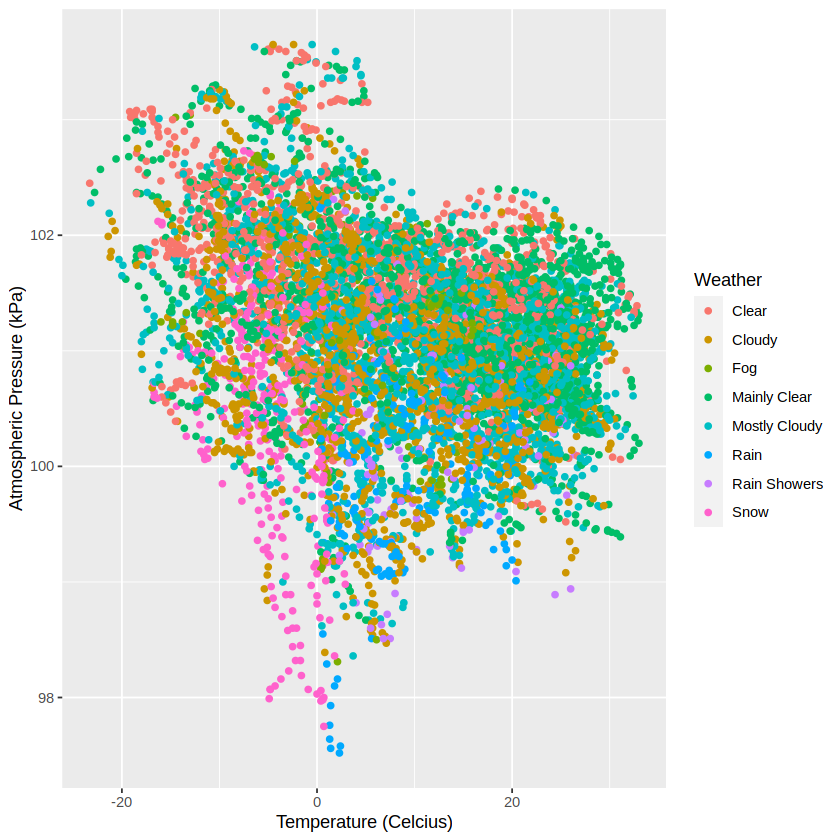

In [4]:
desired_weather <- c("Snow", "Clear", "Rain", "Mostly Clear", "Mainly Clear", "Mostly Cloudy", "Cloudy", "Clear", "Rain Showers", "Fog")

weather_removed_low_count <- weather |>
    filter(Weather %in% desired_weather) |>
    rename(temperature = Temp_C, pressure = Press_kPa, weather = Weather)

weather_data_plot <- weather_removed_low_count |>
    ggplot(aes(x = temperature, y = pressure, color = weather)) +
    geom_point() +
    labs(x = "Temperature (Celcius)", y = "Atmospheric Pressure (kPa)", color = "Weather")

weather_data_plot

Woah! As you can observe, any distinction between classes seems to be masked by overplotted data and lowers our chances of accurately classifying. To combat this, we decided to do some research on how we can distinguish important (real world) variables from the rest.

We found that rain, snow, and clear conditions were often fundamental and easily distinguishable categories, representing distinct atmospheric conditions with significant meanings for various applications. For example, in transportation, rain and snow can impact road safety, while clear weather is generally associated with optimal conditions. Therefore, we select different weather scenarios as the target variable categories. 

Moreover, when observing the distribution of our data, we found that these (rain, snow, and clear) target variable categories are roughly balanced, which improves the accuracy and stability of the prediction model by preventing overfitting one of the variable categories. Observe below...

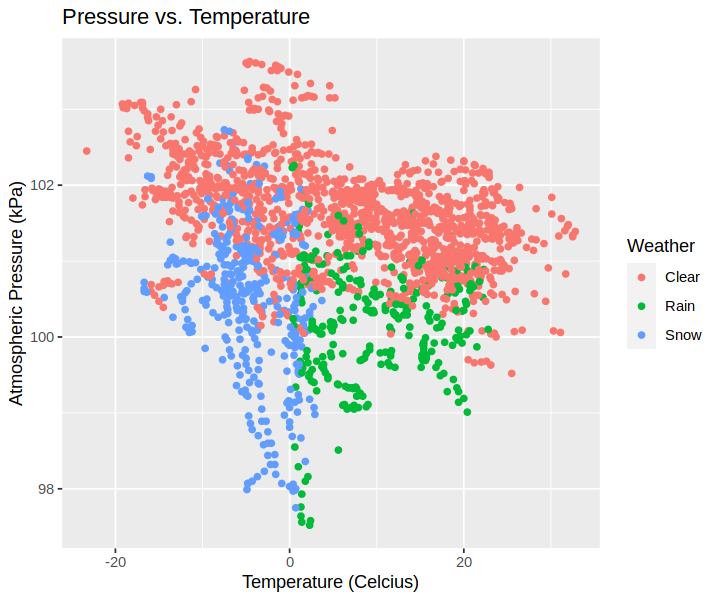

In [15]:
chosen_weather <- c("Snow", "Clear", "Rain")

weather_chosen_variables <- weather |>
    select(Temp_C, Press_kPa, Weather) |>
    filter(Weather %in% chosen_weather) |>
    rename(temperature = Temp_C, pressure = Press_kPa, weather = Weather)

weather_data_plot <- weather_chosen_variables |>
    ggplot(aes(x = temperature, y = pressure, color = weather)) +
    geom_point() +
    labs(x = "Temperature (Celcius)", y = "Atmospheric Pressure (kPa)", title = "Pressure vs. Temperature", color = "Weather")

weather_data_plot

We can now observe a clear distinction between our three weather classes. We also took into account the possibility of combining the Mainly Clear,
Mostly Cloudy, and Rain Showers classes but found that keeping them helped us balance our target variable categories a little better, and prevented overfitting one of the variable categories. 

So no we can begin our classification! But wait, we should first discuss why we're only looking at temperature and atmospheric pressure, right?

# Choosing Our Predictors

Our [weather dataset](https://www.kaggle.com/datasets/bhanupratapbiswas/weather-data) comprises seven forecasted variables, including temperature, precipitation, humidity, wind speed and direction, atmospheric pressure, cloud cover, and UV index. However, for our project, we will concentrate on two of these variables: 

- Temperature
- Atmospheric pressure

Temperature and atmospheric pressure are reliable indicators for predicting weather conditions as: 

- Clear skies are associated with high atmospheric pressure
- Rain occurs in warmer conditions above freezing temperatures
- Snow is commonly linked to colder temperatures below freezing. The interplay between temperature and atmospheric pressure influences cloud formation and precipitation.

Low atmospheric pressure, coupled with specific temperature levels, leads to the convergence and rising of air, causing condensation and the formation of clouds. The interaction of temperature and pressure ultimately determines the type of precipitation—rain if above freezing or snow if below freezing. 

# Begin Classification

To make predictions for new observations, we will use the k-nearest neighbors classification algorithm and cross-validation to choose our k. The first step in our data analysis is to wrangle our data to the conditions as presented above, namely filtering our weather categories (and renaming them for simplicity). Because we already did this earlier, we'll just reassign that to the variable `weather_wrangled`. We'll also **standardize** our data so our data won't be too heavily skewed towards pressure as well ass `bake` the recipe so we can examine the output.

In [28]:
set.seed(2000)

weather_wrangled <- weather_chosen_variables

weather_recipe <- recipe(weather ~ ., data = weather_wrangled) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

weather_scaled <- weather_recipe |>  
                            prep() |> 
                            bake(weather_wrangled)

slice(weather_scaled, 1:6)

temperature pressure    weather
1 -0.1130329  -1.51345396 Rain   
2 -0.1746255  -1.57652603 Rain   
3 -1.6792444  -0.24150070 Snow   
4 -1.9344137   0.58894812 Clear  
5 -1.6528476   0.07385961 Snow   
6 -1.4416730  -0.22047668 Snow

Next we'll split our data into training and testing sets using 0.75 proportion for our training set based on:
- size: enough data point to allocate a smaller percentage for testing so our model is more accurate) 
- complexity: lowered our complexity of parameters so we don't need as large of testing set to get a more accurate estimate of its generalization performance.

In [29]:
set.seed(2000)

weather_split <- initial_split(weather_wrangled, prop = 0.75, strata = weather)

weather_train <- training(weather_split)

weather_test <- testing(weather_split)

Then we will choose our k-value by preforming a 5-fold cross validation and setting our seed to 2000 for reproducibility.

In [30]:
set.seed(2000)

weather_k_vfold <- vfold_cv(weather_train, v = 5, strata = weather)

Next, we can perform the workflow analysis. We will also use our `weather recipe` that we created above and display our results for each k we try. We decided to set our grid to 30 to make sure that we could observe a large range of k values in case there was a peak somewhere that we could have missed.

In [47]:
set.seed(2000)

options(repr.plot.height = 5, repr.plot.width = 6)

weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

weather_workflow <- workflow() |>
                      add_recipe(weather_recipe) |>
                      add_model(weather_spec)

k_vals <- tibble(neighbors = seq(from = 1, to = 30))

weather_results <- weather_workflow |>
    tune_grid(resamples = weather_k_vfold, grid = k_vals) |>
    collect_metrics()

weather_results

neighbors .metric  .estimator mean      n std_err     .config              
1   1        accuracy multiclass 0.8197078 5 0.015271717 Preprocessor1_Model01
2   1        roc_auc  hand_till  0.8231918 5 0.010210621 Preprocessor1_Model01
3   2        accuracy multiclass 0.8183899 5 0.015350164 Preprocessor1_Model02
4   2        roc_auc  hand_till  0.8867734 5 0.007600723 Preprocessor1_Model02
5   3        accuracy multiclass 0.8428257 5 0.013597527 Preprocessor1_Model03
6   3        roc_auc  hand_till  0.9122159 5 0.005591352 Preprocessor1_Model03
7   4        accuracy multiclass 0.8461392 5 0.011598044 Preprocessor1_Model04
8   4        roc_auc  hand_till  0.9211013 5 0.007291634 Preprocessor1_Model04
9   5        accuracy multiclass 0.8362447 5 0.010493249 Preprocessor1_Model05
10  5        roc_auc  hand_till  0.9248731 5 0.005783717 Preprocessor1_Model05
11  6        accuracy multiclass 0.8355825 5 0.010946276 Preprocessor1_Model06
12  6        roc_auc  hand_till  0.9318844 5 0.004358936 Preprocessor1_Model06
13  7        accuracy multiclass 0.8369026 5 0.010605136 Preprocessor1_Model07
14  7        roc_auc  hand_till  0.9331615 5 0.004893649 Preprocessor1_Model07
15  8        accuracy multiclass 0.8369004 5 0.011354918 Preprocessor1_Model08
16  8        roc_auc  hand_till  0.9356536 5 0.005192105 Preprocessor1_Model08
17  9        accuracy multiclass 0.8435231 5 0.009180708 Preprocessor1_Model09
18  9        roc_auc  hand_till  0.9365603 5 0.004861460 Preprocessor1_Model09
19 10        accuracy multiclass 0.8441831 5 0.008681442 Preprocessor1_Model10
20 10        roc_auc  hand_till  0.9377910 5 0.006103877 Preprocessor1_Model10
21 11        accuracy multiclass 0.8461699 5 0.008532713 Preprocessor1_Model11
22 11        roc_auc  hand_till  0.9375008 5 0.006606570 Preprocessor1_Model11
23 12        accuracy multiclass 0.8481589 5 0.007712223 Preprocessor1_Model12
24 12        roc_auc  hand_till  0.9379643 5 0.006699927 Preprocessor1_Model12
25 13        accuracy multiclass 0.8455252 5 0.008120925 Preprocessor1_Model13
26 13        roc_auc  hand_till  0.9366516 5 0.007024609 Preprocessor1_Model13
27 14        accuracy multiclass 0.8475032 5 0.007206948 Preprocessor1_Model14
28 14        roc_auc  hand_till  0.9365990 5 0.006723305 Preprocessor1_Model14
29 15        accuracy multiclass 0.8415538 5 0.006845786 Preprocessor1_Model15
30 15        roc_auc  hand_till  0.9379466 5 0.006559053 Preprocessor1_Model15
31 16        accuracy multiclass 0.8395714 5 0.006585496 Preprocessor1_Model16
32 16        roc_auc  hand_till  0.9372850 5 0.006914279 Preprocessor1_Model16
33 17        accuracy multiclass 0.8415778 5 0.003668871 Preprocessor1_Model17
34 17        roc_auc  hand_till  0.9380132 5 0.006652775 Preprocessor1_Model17
35 18        accuracy multiclass 0.8422335 5 0.004673174 Preprocessor1_Model18
36 18        roc_auc  hand_till  0.9379377 5 0.006573055 Preprocessor1_Model18
37 19        accuracy multiclass 0.8336482 5 0.005482015 Preprocessor1_Model19
38 19        roc_auc  hand_till  0.9368486 5 0.006766337 Preprocessor1_Model19
39 20        accuracy multiclass 0.8329816 5 0.006438245 Preprocessor1_Model20
40 20        roc_auc  hand_till  0.9371343 5 0.006010013 Preprocessor1_Model20
41 21        accuracy multiclass 0.8343083 5 0.006950281 Preprocessor1_Model21
42 21        roc_auc  hand_till  0.9370911 5 0.006379213 Preprocessor1_Model21
43 22        accuracy multiclass 0.8343083 5 0.006950281 Preprocessor1_Model22
44 22        roc_auc  hand_till  0.9366918 5 0.006487810 Preprocessor1_Model22
45 23        accuracy multiclass 0.8349661 5 0.005537045 Preprocessor1_Model23
46 23        roc_auc  hand_till  0.9364134 5 0.006086409 Preprocessor1_Model23
47 24        accuracy multiclass 0.8369420 5 0.006089320 Preprocessor1_Model24
48 24        roc_auc  hand_till  0.9361417 5 0.006284270 Preprocessor1_Model24
49 25        accuracy multiclass 0.8362907 5 0.005850781 Preprocessor1_Model25
50 25        roc_auc  hand_till  0.9351574 5 0.006645

We can now take a look at a graph of k accuracies between 1 and 30 to see which one is most accurate for our model to use. We suspect this value will be relatively high as we have some overlap in "areas" of distinction and need enough k's to dictate an accurate class.

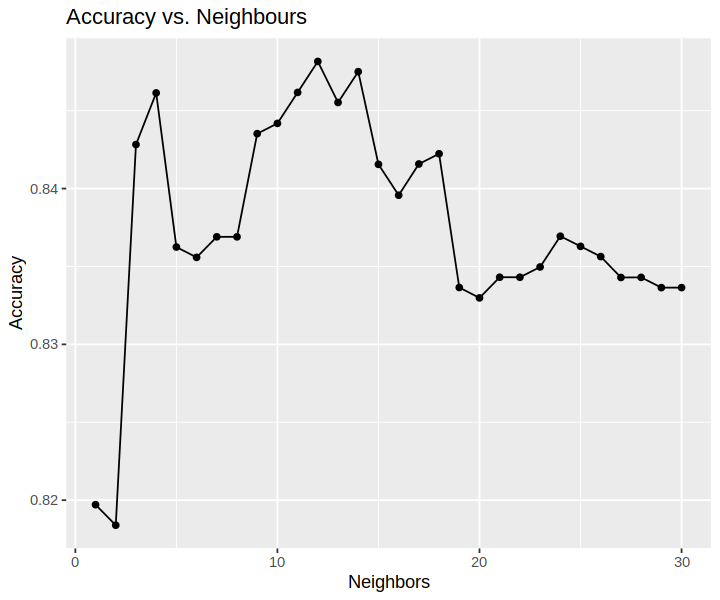

In [46]:
weather_accuracies <- weather_results |>
    filter(.metric == "accuracy")

cross_val_plot <- weather_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy", title = "Accuracy vs. Neighbours")

cross_val_plot

We can see by our graph above, that having k = 12 neighbours would give us the highest accuracy where its left and right points do not vary durastically in accuracy. This make intuitive sense as we have some overlapping "sections" of classes in our graph and so utilizing a slightly higher k value would be most beneficial to encompass a wider radius of datapoints.

In [12]:
set.seed(2000)

weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode("classification")

weather_results <- workflow() |>
    add_recipe(weather_recipe) |>
    add_model(weather_spec) |>
    fit(data = weather_train)

weather_results

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1485149
Best kernel: rectangular
Best k: 6

# Classifying Our Testing Data
We can now try to predict the class label for our testing set `weather_test` using what we found above.

In [ ]:
weather_test_predictions <- predict(weather_results, weather_test)|>
    bind_cols(weather_test)
    weather_test_predictions

And finally, lets look at how accurate we are classifying our testing data.

In [ ]:
weather_prediction_accuracy <- weather_test_predictions |>
    metrics(truth = weather, estimate = .pred_class)
    
weather_prediction_accuracy

## Discussion

#### Summary of Our Findings
We found a strong correlation between our predictors and target variables through an analysis that aligned with our expectations, demonstrating high accuracy in classifying rain, snow, and clear weather based on atmospheric pressure and temperature variables.


#### Expectations vs. Reality
The interplay of these factors influences weather changes. While a model using atmospheric pressure and temperature aids in predicting future weather conditions, we did expect that the overlapping data points in visualizations suggest the complexity of weather influenced by various factors like wind, humidity, and precipitation. This would be a clear indication as to why our accuracy was a bit aways from perfect, but it still displays a strong correlation between our chosen factors.

#### Impacts of Our Findings
The recognition of the Earth's atmosphere as a complex and chaotic system underscores the challenges in achieving long-term weather prediction accuracy, given its sensitivity to initial conditions. Despite these challenges, our study highlights the crucial role of weather prediction in ensuring safety, supporting economic activities, and informing decision-making processes. This emphasizes the ongoing need for advancements in forecasting models to mitigate uncertainties and enhance the reliability of weather predictions. The implications extend beyond scientific understanding, impacting daily life, various industries, and societal resilience.

#### Ongoing Questions
The study prompts exploration of additional predictors for improved accuracy, raising questions about the impact of diverse geographical data on results and suggesting avenues for future research to enhance forecasting models.